In [1]:
import pandas as pd
import shap
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from econml.grf import CausalForest

# Pre-process data

In [2]:
data = pd.read_csv("bsc_project_set.csv", index_col=0)

xs = data.copy()

y = xs["mort_28"]
w = xs["peep_regime"]

w = pd.Series(map(lambda x: 0 if x == "low" else 1, w))
y = pd.Series(map(lambda x: 1 if x == False else 0, y))

selected_columns = ["age", "weight", "pf_ratio", "po2", "pco2", "driving_pressure", "bilirubin", "platelets", "urea", "fio2", "minute_volume", "plateau_pressure"]
xs = xs[selected_columns]
columns_x = xs.columns

norm_xs = (xs - xs.mean())/xs.std()

imputer = KNNImputer(n_neighbors=2, weights="uniform")
imp_xs = imputer.fit_transform(norm_xs)

imp_xs = pd.DataFrame(data=imp_xs, columns=columns_x)

imp_xs

,age,weight,pf_ratio,po2,pco2,driving_pressure,bilirubin,platelets,urea,fio2,minute_volume,plateau_pressure
0,0.732971,0.183841,-0.026374,-0.049713,-1.422636,-0.364306,1.121030,-1.048713,-0.897592,-0.564826,-0.543738,0.705302
1,-1.005004,1.422974,-0.637005,-0.385550,-0.768253,-1.141620,2.210067,-1.629822,2.693985,0.758913,3.032717,-0.620678
2,1.353676,-0.381057,-0.171336,-0.406111,-0.403630,1.468983,0.409822,-0.668334,0.703662,-0.434729,-0.035368,0.317210
3,1.353676,0.100018,-0.319055,-1.169822,-0.403630,1.395651,-0.190259,0.023680,1.738181,-1.503965,-0.868889,0.640620
4,0.050195,-0.654395,-0.577049,-0.737052,-0.334933,-1.072479,-0.531046,2.898673,-0.720674,-0.385943,-1.051634,-1.236080
...,...,...,...,...,...,...,...,...,...,...,...,...
3936,0.919183,-1.128181,-0.711144,0.068026,-0.395043,1.219655,-0.068020,0.112283,0.478767,0.541000,-0.428608,0.252528
3937,0.732971,0.475402,-0.527518,-0.793421,-0.300585,-0.540301,-0.501413,-1.092709,2.250942,-0.411497,-0.966353,-1.028174
3938,0.236407,0.438957,-0.701828,-0.554080,0.137359,0.281012,0.325366,1.026414,0.532742,1.377339,-0.299739,1.869576
3939,0.298477,0.245798,-0.425805,-0.814696,-0.156321,0.075683,0.009768,-0.423609,-0.522017,0.150708,-0.298318,0.113924


In [3]:
full_data = imp_xs.assign(W=w, Y=y)

# S-learner

PermutationExplainer explainer: 3942it [52:12,  1.26it/s]                          


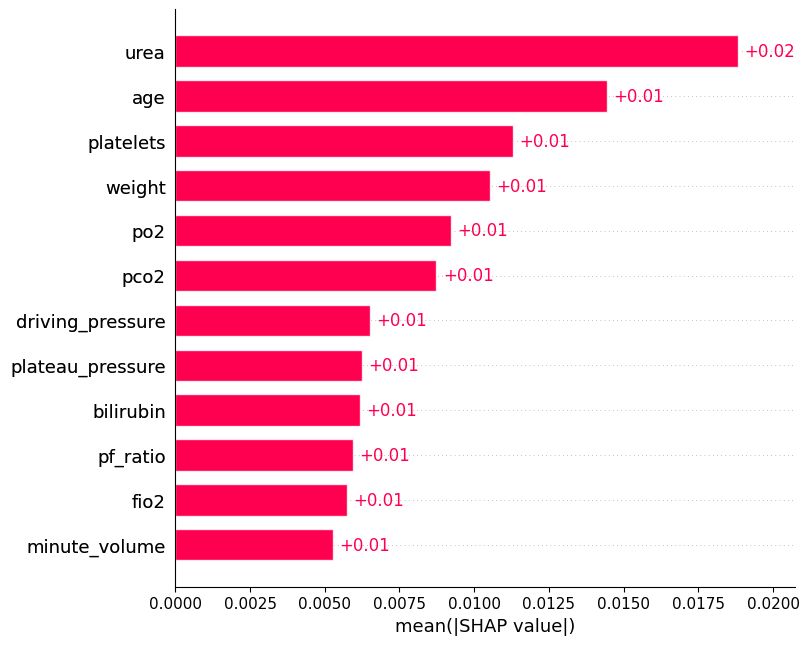

In [6]:
regr_s = RandomForestRegressor()
regr_s.fit(full_data.drop(columns=["Y"]), full_data["Y"])
explainer_s = shap.Explainer(model=(lambda xs: regr_s.predict(xs.assign(**{"W": 1})) - regr_s.predict(xs.assign(**{"W": 0}))), masker=shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_s = explainer_s(imp_xs)
shap.plots.bar(shap_values_s, max_display=12)

PermutationExplainer explainer: 3942it [53:35,  1.22it/s]                          


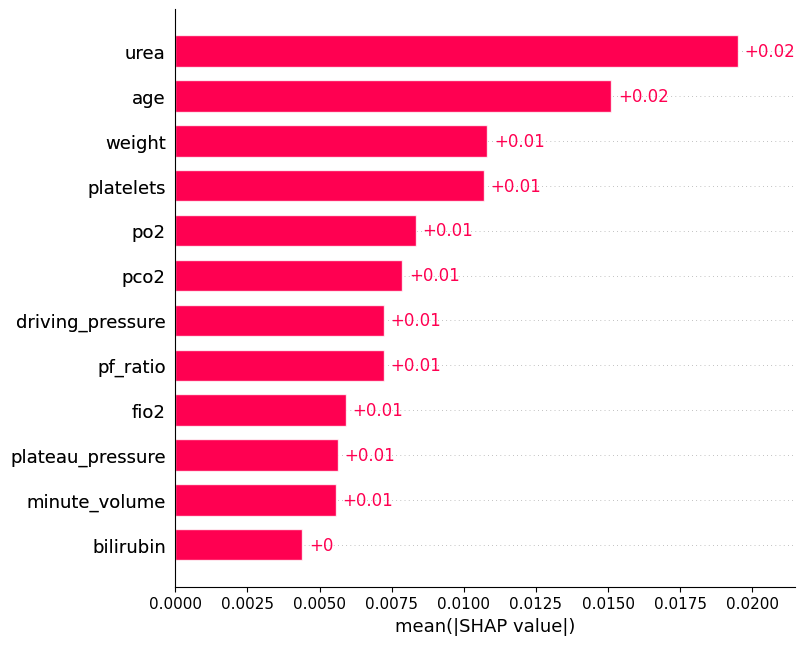

In [7]:
regr_s = RandomForestRegressor()
regr_s.fit(full_data.drop(columns=["Y"]), full_data["Y"])
explainer_s = shap.Explainer(model=(lambda xs: regr_s.predict(xs.assign(**{"W": 1})) - regr_s.predict(xs.assign(**{"W": 0}))), masker=shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_s = explainer_s(imp_xs)
shap.plots.bar(shap_values_s, max_display=12)

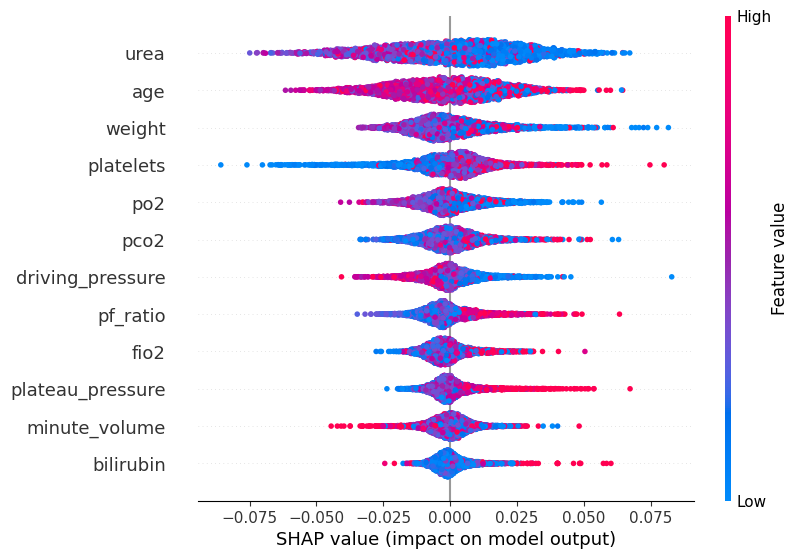

In [8]:
shap.plots.beeswarm(shap_values_s, max_display=12)

PermutationExplainer explainer: 3942it [2:07:34,  1.94s/it]                            


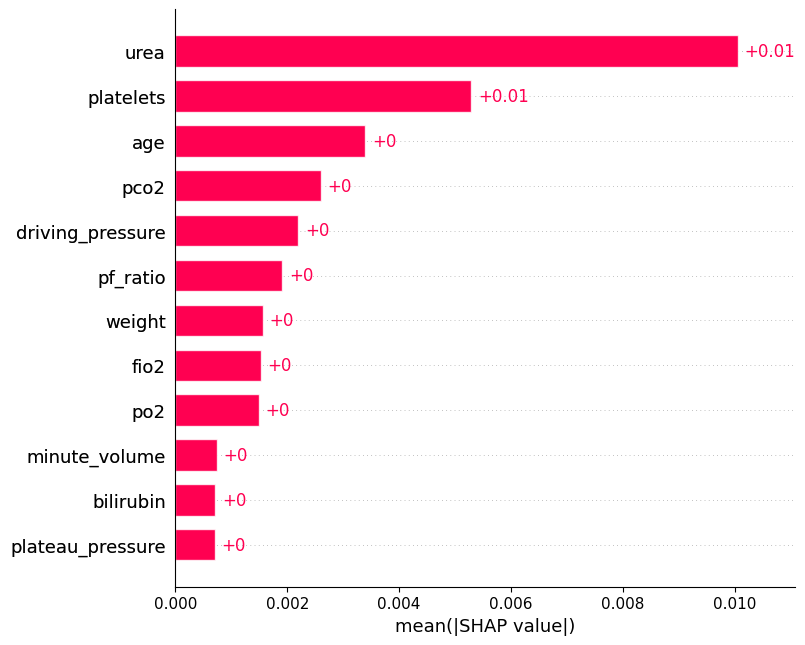

In [15]:
regr_s = RandomForestRegressor(max_depth=5, min_samples_split=5, n_estimators=500, max_samples=0.5)
regr_s.fit(full_data.drop(columns=["Y"]), full_data["Y"])
explainer_s = shap.Explainer(model=(lambda xs: regr_s.predict(xs.assign(**{"W": 1})) - regr_s.predict(xs.assign(**{"W": 0}))), masker=shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_s = explainer_s(imp_xs)
shap.plots.bar(shap_values_s, max_display=12)

# T-learner

PermutationExplainer explainer: 3942it [42:42,  1.53it/s]                          


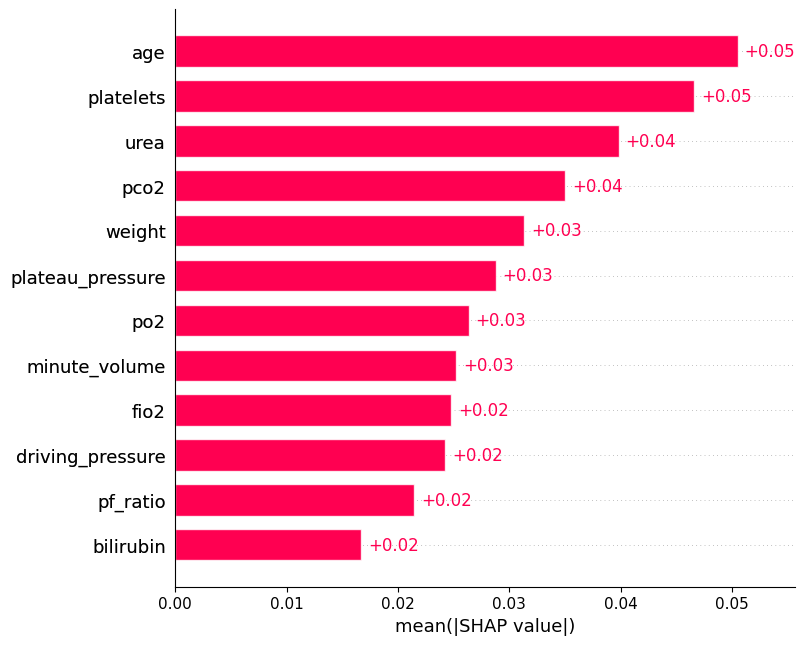

In [9]:
regr0_t = RandomForestRegressor()
regr1_t = RandomForestRegressor()
regr0_t.fit(full_data.query("W==0").drop(columns=["W", "Y"]), full_data.query("W==0")["Y"])
regr1_t.fit(full_data.query("W==1").drop(columns=["W", "Y"]), full_data.query("W==1")["Y"])
explainer_t = shap.Explainer(model=(lambda xs: regr1_t.predict(xs) - regr0_t.predict(xs)),
                             masker=shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_t = explainer_t(imp_xs)
shap.plots.bar(shap_values_t, max_display=12)

PermutationExplainer explainer: 3942it [43:42,  1.50it/s]                          


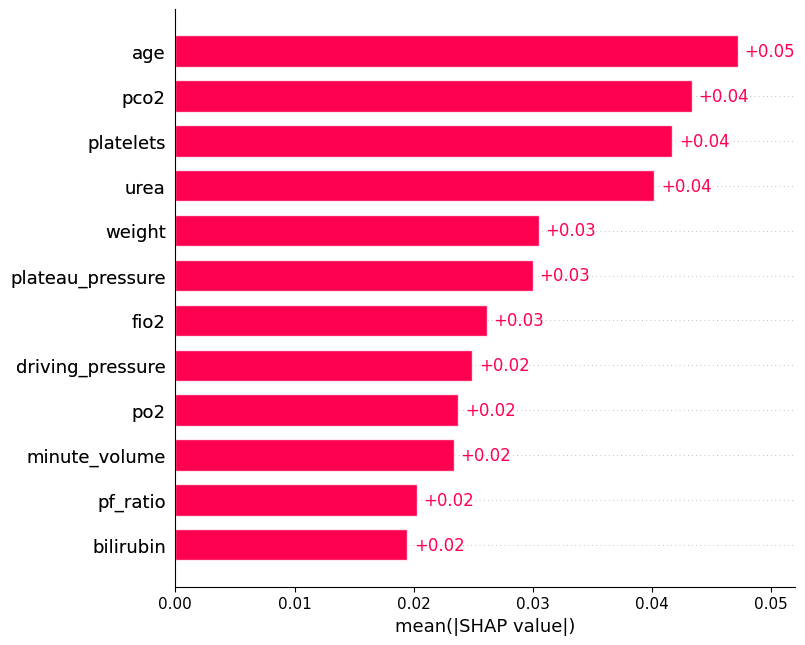

In [10]:
regr0_t = RandomForestRegressor()
regr1_t = RandomForestRegressor()
regr0_t.fit(full_data.query("W==0").drop(columns=["W", "Y"]), full_data.query("W==0")["Y"])
regr1_t.fit(full_data.query("W==1").drop(columns=["W", "Y"]), full_data.query("W==1")["Y"])
explainer_t = shap.Explainer(model=(lambda xs: regr1_t.predict(xs) - regr0_t.predict(xs)),
                             masker=shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_t = explainer_t(imp_xs)
shap.plots.bar(shap_values_t, max_display=12)

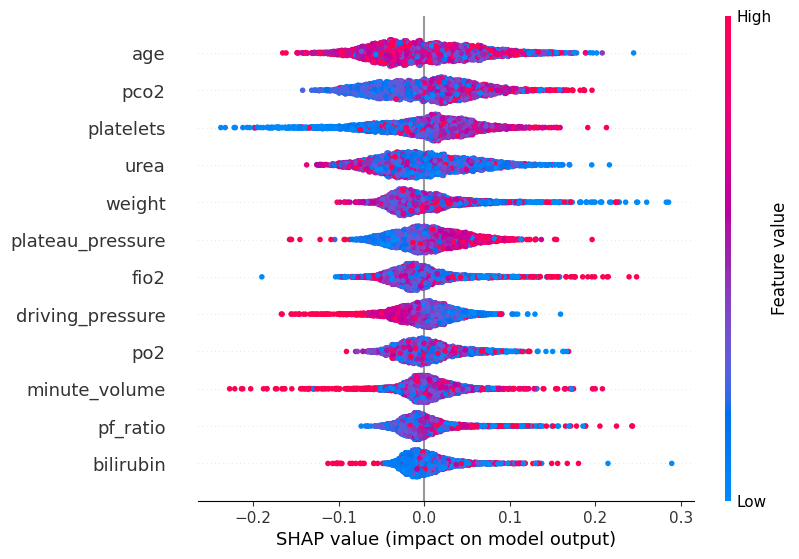

In [11]:
shap.plots.beeswarm(shap_values_t, max_display=12)

PermutationExplainer explainer: 3942it [1:37:35,  1.49s/it]                          


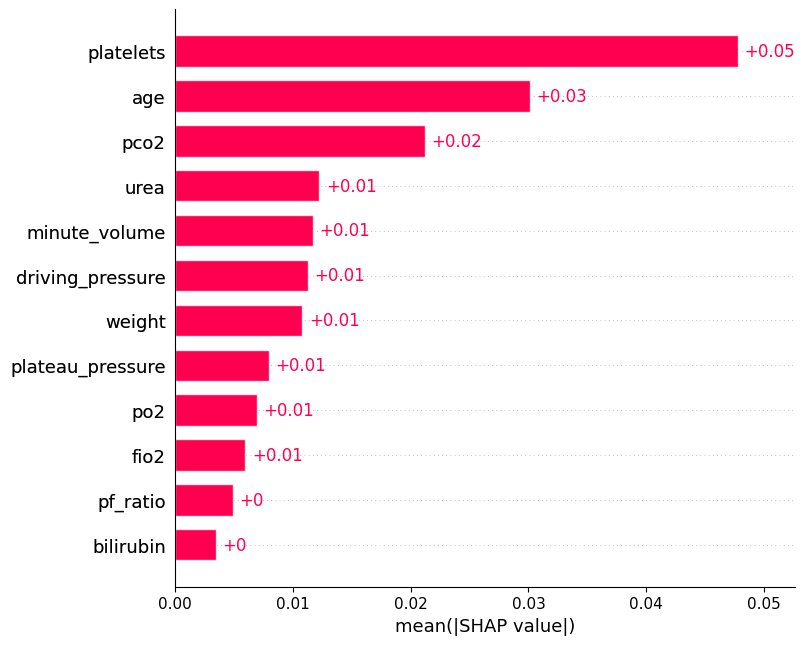

In [16]:
regr0_t = RandomForestRegressor(max_depth=3, min_samples_split=5, n_estimators=500, max_samples=0.5)
regr1_t = RandomForestRegressor(max_depth=3, min_samples_split=5, n_estimators=500, max_samples=0.5)
regr0_t.fit(full_data.query("W==0").drop(columns=["W", "Y"]), full_data.query("W==0")["Y"])
regr1_t.fit(full_data.query("W==1").drop(columns=["W", "Y"]), full_data.query("W==1")["Y"])
explainer_t = shap.Explainer(model=(lambda xs: regr1_t.predict(xs) - regr0_t.predict(xs)),
                             masker=shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_t = explainer_t(imp_xs)
shap.plots.bar(shap_values_t, max_display=12)

# Causal Forest

PermutationExplainer explainer: 3942it [45:17,  1.45it/s]                          


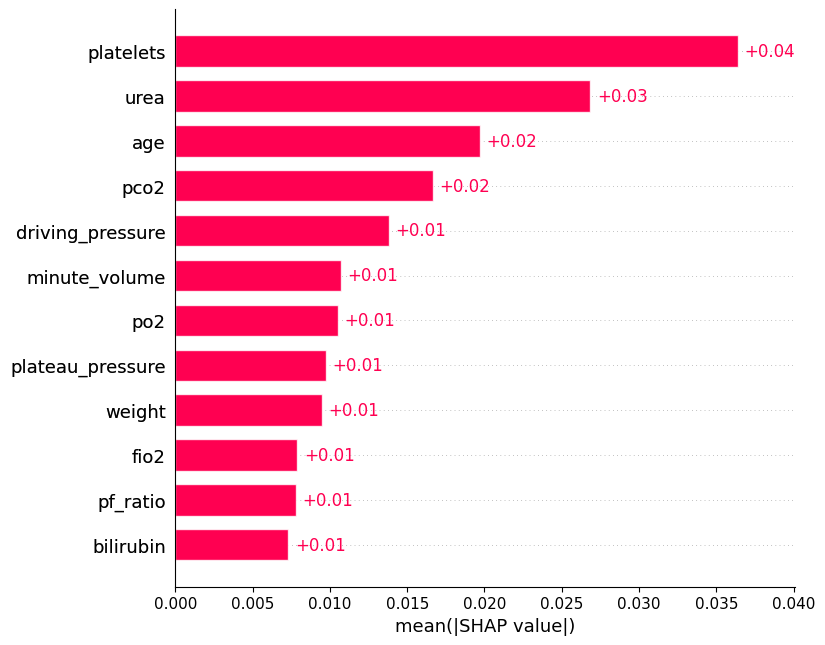

In [12]:
causal_forest = CausalForest()
causal_forest.fit(X=full_data.drop(columns=["W", "Y"]), T=full_data["W"], y=full_data["Y"])
explainer_forest = shap.Explainer(causal_forest.predict, masker=shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_forest = explainer_forest(imp_xs)
shap.plots.bar(shap_values_forest, max_display=12)

PermutationExplainer explainer: 3942it [48:00,  1.36it/s]                          


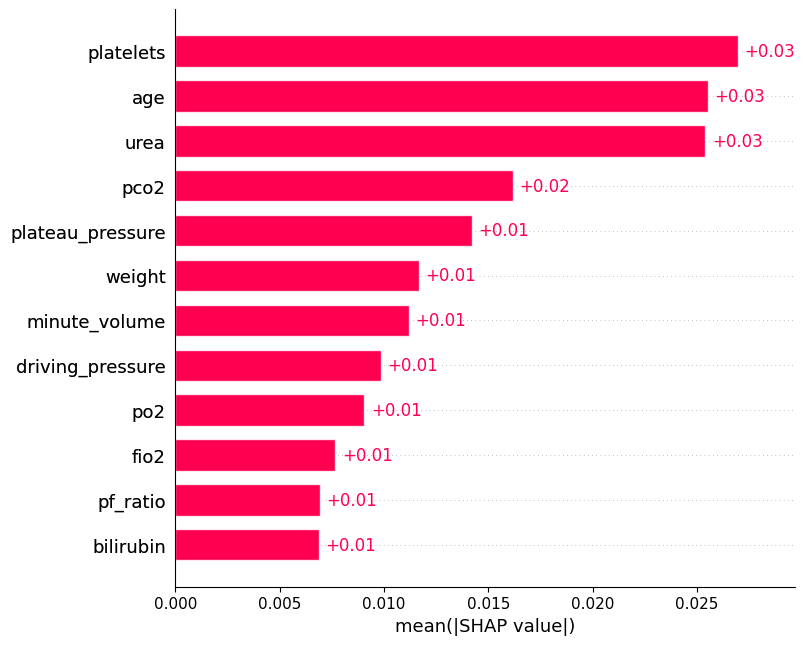

In [13]:
causal_forest = CausalForest()
causal_forest.fit(X=full_data.drop(columns=["W", "Y"]), T=full_data["W"], y=full_data["Y"])
explainer_forest = shap.Explainer(causal_forest.predict, masker=shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_forest = explainer_forest(imp_xs)
shap.plots.bar(shap_values_forest, max_display=12)

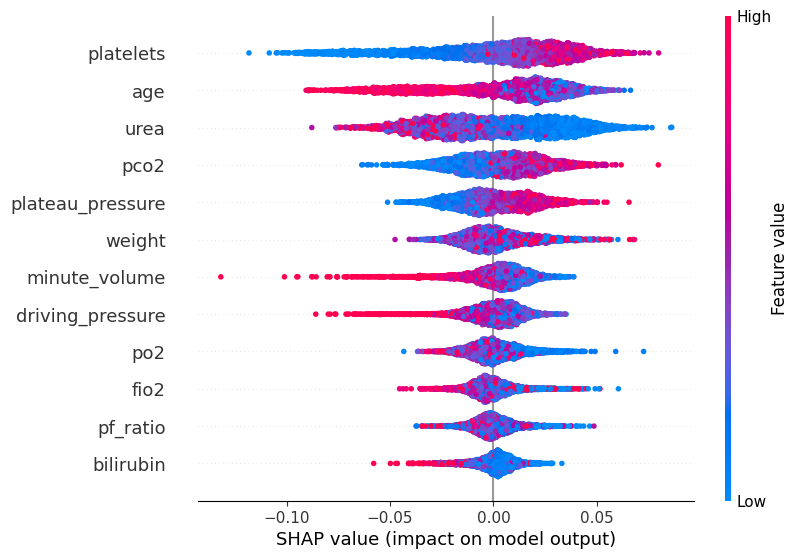

In [14]:
shap.plots.beeswarm(shap_values_forest, max_display=12)

PermutationExplainer explainer: 3942it [9:24:11,  8.59s/it]                            


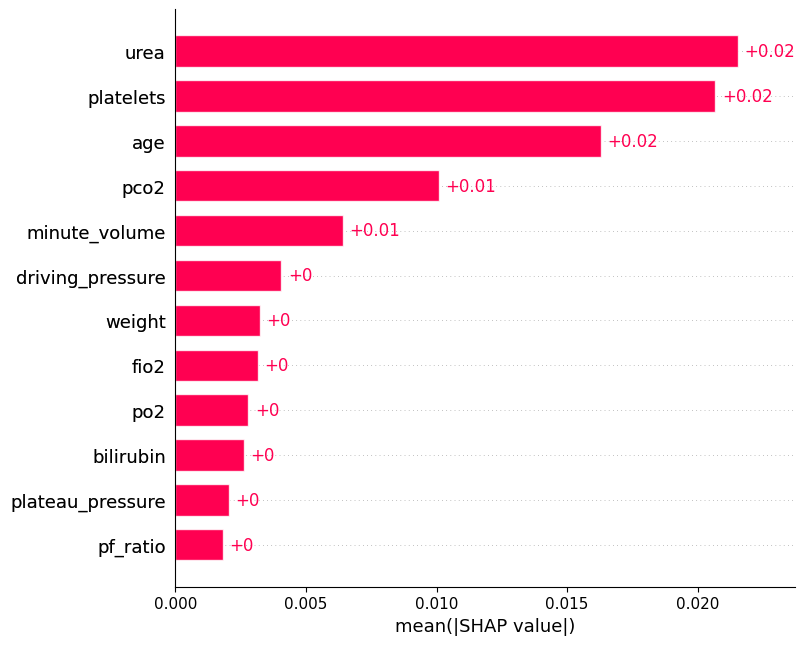

In [17]:
causal_forest = CausalForest(max_depth=5, min_samples_split=10, n_estimators=2500)
causal_forest.fit(X=full_data.drop(columns=["W", "Y"]), T=full_data["W"], y=full_data["Y"])
explainer_forest = shap.Explainer(causal_forest.predict, masker=shap.maskers.Independent(imp_xs, max_samples=100))
shap_values_forest = explainer_forest(imp_xs)
shap.plots.bar(shap_values_forest, max_display=12)